# Introduction to dMRI data

In [1]:
import warnings
from eddymotion.viz import plot_dwi

warnings.filterwarnings("ignore")


def _data_repr(value):
    if value is None:
        return "None"
    return f"<{'x'.join(str(v) for v in value.shape)} ({value.dtype})>"

Diffusion imaging probes the random, microscopic motion of water protons by using MRI sequences that are sensitive to the geometry and environmental organization surrounding these protons.
This is a popular technique for studying the white matter of the brain.
The diffusion within biological structures, such as the brain, are often restricted due to barriers (eg. cell membranes), resulting in a preferred direction of diffusion (anisotropy).
A typical dMRI scan will acquire multiple volumes (or ***angular samples***), each sensitive to a particular ***diffusion direction***.
These *diffusion directions* (or ***orientations***) are a fundamental piece of metadata to interpret dMRI data, as models need to know the exact orientation of each angular sample.

```{admonition} Main elements of a dMRI dataset
- A 4D data array, where the last dimension encodes the reconstructed **diffusion direction *maps***.
- Tabular data or a 2D array, listing the **diffusion directions** and the encoding gradient strength.
```

In summary, dMRI involves ***complex data types*** that, as programmers, we want to access, query and manipulate with ease.

## Python and object oriented programming

Python is an [object oriented programming](https://en.wikipedia.org/wiki/Object-oriented_programming) language, which represent and encapsulate data types and corresponding behaviors into programming structures called *objects*.

Therefore, let's leverage Python to create *objects* that contain dMRI data.
In Python, *objects* can be specified by defining a class with name `DWI`.
To simplify class creation, we'll use the magic of a Python library called [`attrs`](https://www.attrs.org/en/stable/).

In [2]:
"""Representing data in hard-disk and memory."""
import attr


@attr.s(slots=True)
class DWI:
    """Data representation structure for dMRI data."""

    dataobj = attr.ib(default=None, repr=_data_repr)
    """A numpy ndarray object for the data array, without *b=0* volumes."""
    brainmask = attr.ib(default=None, repr=_data_repr)
    """A boolean ndarray object containing a corresponding brainmask."""
    bzero = attr.ib(default=None, repr=_data_repr)
    """A *b=0* reference map, preferably obtained by some smart averaging."""
    gradients = attr.ib(default=None, repr=_data_repr)
    """A 2D numpy array of the gradient table in RAS+B format."""
    em_affines = attr.ib(default=None)
    """
    List of :obj:`nitransforms.linear.Affine` objects that bring
    DWIs (i.e., no b=0) into alignment.
    """

    def __len__(self):
        """Obtain the number of high-*b* orientations."""
        return self.gradients.shape[-1]


This first code implements several *attributes* and the first *behavior* - the `__len__` *method*.
The `__len__` method is special in Python, as it will be executed when we call the built-in function `len()` on our object.
Let's test this memory structure with some *simulated* data:

In [3]:
# NumPy is a fundamental Python library
import numpy as np

# Let's create a new DWI object, with only gradient information that is random
dmri_dataset = DWI(gradients=np.random.normal(size=(4, 64)))

# Let's call Python's built-in len() function
print(len(dmri_dataset))

64


The output of this `print()` statement is telling us that this (simulated) dataset has 64 diffusion weighted samples.

## Using the new data representation object
For simplicity, we will be using the full implementation of the `DWI` class from our [`eddymotion` package](https://github.com/nipreps/EddyMotionCorrection/blob/57c518929146b23cc9534ab0b2d024aa136e25f8/emc/dmri.py)
Under the `data/` folder of this book's distribution, we have stored a sample DWI dataset with filename `dwi.h5`.
Please note that the file has been minimized by zeroing all but two diffusion weighted orientation maps.
Let's get some insights from it:

In [4]:
# Import the class from the library
from eddymotion.dmri import DWI

# Load the sample file
dmri_dataset = DWI.from_filename("../../data/dwi.h5")
print(len(dmri_dataset))

102


In this case, the dataset is reporting to have 102 diffusion weighted samples.

Python will automatically generate a summary of this object if we just issue the name of our new object.
This pretty-printing of the object informs us about the data and metadata that together compose this particular DWI dataset:

In [5]:
dmri_dataset

DWI(dataobj=<118x118x78x102 (int16)>, affine=<4x4 (float64)>, brainmask=None, bzero=<118x118x78 (int16)>, gradients=<4x102 (float32)>, em_affines=None, fieldmap=None)

### Visualizing the data

The fully-fledged `DWI` object has a convenience function to plot the dataset:

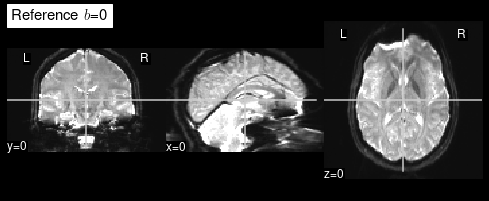

In [6]:
dmri_dataset.plot_mosaic();

When calling `plot_mosaic()` without arguments, the *b=0* reference is plotted.
This *b=0* reference is a map of the signal measured ***without gradient sensitization***, or in other words, when we are not measuring diffusion in any direction.
The *b=0* map can be used by diffusion modeling as the reference to quantify the signal drop at every voxel and given a particular orientation gradient.

We can also get an insight of how a diffusion weighted orientation looks like by selecting them with the argument `index`:

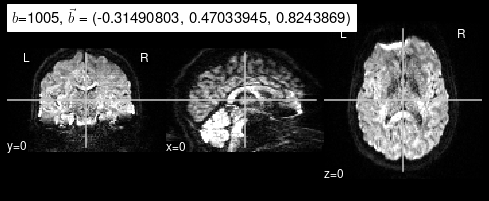

In [7]:
dmri_dataset.plot_mosaic(index=10);

or:

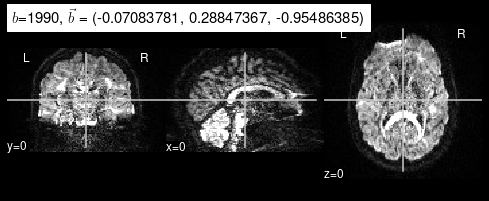

In [8]:
dmri_dataset.plot_mosaic(index=100);

As we can see, ***diffusion weighted*** images consistently drop almost all signal in voxels filled with cerebrospinal fluid because there, water-diffusion is free regardless of the direction you are measuring in.

### Visualizing the gradient information

Our `DWI` object stores the gradient information in the `gradients` attribute:

In [9]:
dmri_dataset.gradients.shape

(4, 102)

### The *LOGO* (leave-one-gradient-out) splitter
One final behavior that will make our endeavor easier in the long run is a convenience method for data splitting.
In particular, we are implementing some sort of cross-validation scheme where we will iterate over different data splits.
In this case, the splitting strategy is a simple leave-one-out.
Because one "*datapoint*" in our DW dataset corresponds to one gradient, we will refer to this partitioning of the dataset as *leave-one-gradient-out (LOGO)*:

In [10]:
    def logo_split(self, index, with_b0=False):
        """
        Produce one fold of LOGO (leave-one-gradient-out).
        
        Parameters
        ----------
        index : :obj:`int`
            Index of the DWI orientation to be left out in this fold.
        with_b0 : :obj:`bool`
            Insert the *b=0* reference at the beginning of the training dataset.

        Return
        ------
        (train_data, train_gradients) : :obj:`tuple`
            Training DWI and corresponding gradients.
            Training data/gradients come **from the updated dataset**.
        (test_data, test_gradients) :obj:`tuple`
            Test 3D map (one DWI orientation) and corresponding b-vector/value.
            The test data/gradient come **from the original dataset**.

        """
        dwframe = self.dataobj[..., index]
        bframe = self.gradients[..., index]

        # if the size of the mask does not match data, cache is stale
        mask = np.zeros(len(self), dtype=bool)
        mask[index] = True

        train_data = self.dataobj[..., ~mask]
        train_gradients = self.gradients[..., ~mask]

        if with_b0:
            train_data = np.concatenate(
                (np.asanyarray(self.bzero)[..., np.newaxis], train_data),
                axis=-1,
            )
            b0vec = np.zeros((4, 1))
            b0vec[0, 0] = 1
            train_gradients = np.concatenate(
                (b0vec, train_gradients),
                axis=-1,
            )

        return (
            (train_data, train_gradients),
            (dwframe, bframe),
        )

This function will allow us to easily partition the dataset as follows:

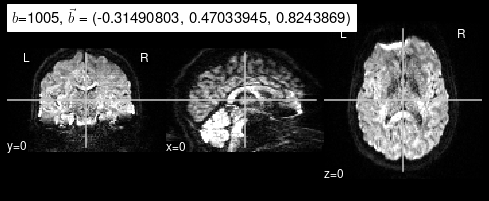

In [11]:
data_train, data_test = dmri_dataset.logo_split(10)
plot_dwi(data_test[0], dmri_dataset.affine, gradient=data_test[1]);

where `data_train` is a tuple containing all DW volumes and corresponding gradient table excluding the left-out, which is store in `data_test`.
Consequently, `data_test[0]` contains the held-out DW map and `data_test[1]` the corresponding gradient vector (RAS+B format).